In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import gc

import matplotlib.pyplot as plt
import seaborn as sns

import requests
import xmltodict
import json

from datetime import datetime

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거
warnings.filterwarnings(action='ignore')

In [27]:
# def csv_to_parquet(csv_path, save_name):
#     df = pd.read_csv(csv_path)
#     df.to_parquet(f'./data/{save_name}.parquet')
#     del df
#     gc.collect()
#     print(save_name, 'Done.')

In [28]:
# csv_to_parquet('./data/train.csv', 'train')
# csv_to_parquet('./data/test.csv', 'test')

In [29]:
# train = pd.read_parquet('./data/train.parquet')
# test = pd.read_parquet('./data/test.parquet')

### 데이터 불러오기

In [30]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [31]:
train[130:140]

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
130,TRAIN_0000130,20220118,화,8,1,107,한천로,0,0,60.0,...,0,제3한천교,33.502900,126.511234,없음,오라오거리,33.500330,126.505998,있음,19.0
131,TRAIN_0000131,20220212,토,18,2,103,일반국도11호선,0,0,60.0,...,0,영주교,33.305359,126.598914,없음,하례입구삼거리,33.300796,126.600332,없음,52.0
132,TRAIN_0000132,20211203,금,12,2,103,일반국도12호선,0,0,50.0,...,0,외도초교앞삼거리,33.493661,126.433789,없음,외도교,33.494067,126.435871,없음,39.0
133,TRAIN_0000133,20220220,일,11,1,103,일반국도16호선,0,0,60.0,...,0,제2가시교,33.364471,126.769568,없음,성읍교차로,33.381730,126.792312,없음,54.0
134,TRAIN_0000134,20211030,토,9,1,106,지방도1120호선,0,0,60.0,...,0,명월사거리,33.392366,126.263513,없음,명월입구,33.393189,126.263195,없음,43.0
135,TRAIN_0000135,20211008,금,21,2,106,중산간서로,0,0,50.0,...,0,더럭초교차로,33.452396,126.344994,없음,쉬는팡교차로,33.451901,126.341998,없음,35.0
136,TRAIN_0000136,20220731,일,9,3,103,일반국도16호선,0,0,70.0,...,0,해안육교,33.465863,126.456384,없음,제1해안교,33.463342,126.454106,없음,38.0
137,TRAIN_0000137,20211013,수,3,2,103,일반국도12호선,0,0,80.0,...,3,한대교,33.417996,126.277208,없음,한대교,33.418339,126.277314,없음,59.0
138,TRAIN_0000138,20220104,화,2,1,106,지방도1120호선,0,0,50.0,...,3,명월교,33.393972,126.263060,없음,명월교,33.394228,126.263042,없음,59.0
139,TRAIN_0000139,20210902,목,21,3,106,지방도1132호선,0,0,50.0,...,3,삼양검은모래해변입구교차로,33.521399,126.587288,있음,삼양동사무소,33.521098,126.585400,없음,18.0


In [32]:
train.isnull().sum()

id                       0
base_date                0
day_of_week              0
base_hour                0
lane_count               0
road_rating              0
road_name                0
multi_linked             0
connect_code             0
maximum_speed_limit      0
vehicle_restricted       0
weight_restricted        0
height_restricted        0
road_type                0
start_node_name          0
start_latitude           0
start_longitude          0
start_turn_restricted    0
end_node_name            0
end_latitude             0
end_longitude            0
end_turn_restricted      0
target                   0
dtype: int64

![한국도로공사](%ED%95%9C%EA%B5%AD%EB%8F%84%EB%A1%9C%EA%B3%B5%EC%82%AC.png)

확인 해볼거
- 추이 그래프 (날짜별, 시간대별, 요일별)
- 공휴일
- 눈, 기온, 비 순으로 교통량과 관계가 밀접
- 전체 지도별 도로 표시
- 컬럼이 너무 많아서 각 컬럼별 상관계수

### 년도/월/일별 추이 그래프

In [33]:
train["datetime"] = pd.to_datetime(train["base_date"],format='%Y%m%d')

In [34]:
train['base_date'].min()

20210901

In [35]:
train['base_date'].max()

20220731

In [36]:
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day

### 

In [89]:
train_date = train[['datetime','target']]
train_date = train_date.groupby('datetime').mean().reset_index()

train_time = train[['base_hour','target']]
train_time = train_time.groupby('base_hour').mean().reset_index()

train_day = train[['day_of_week','target']]
train_day = train_day.groupby('day_of_week').mean()
train_day = train_day.reindex(['월','화','수','목','금','토','일']).reset_index()

train_date.head()


,datetime,target
0,2021-09-01,43.760268
1,2021-09-02,43.769578
2,2021-09-03,43.692354
3,2021-09-04,44.084787
4,2021-09-05,44.136858


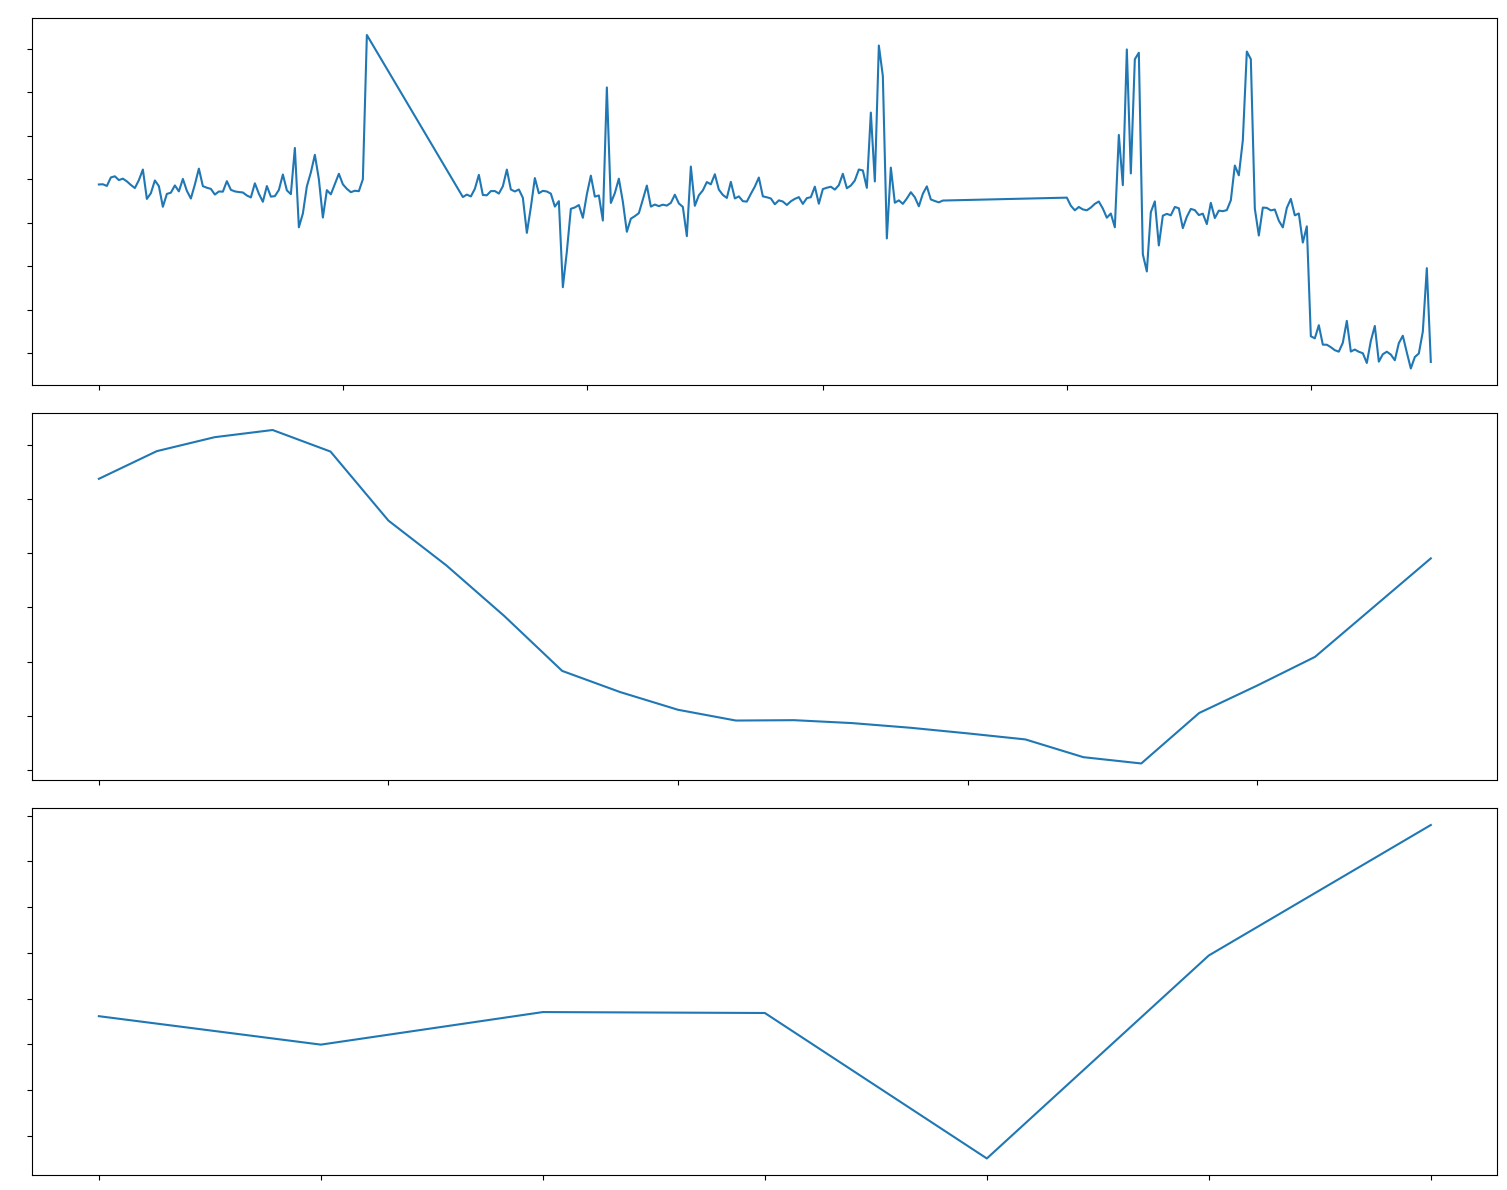

In [38]:
fig, axes = plt.subplots(3, figsize=(15,12))

sns.lineplot(x='datetime',y='target',data=train_date,ax=axes[0]).set(title='base_date vs target')
sns.lineplot(x='base_hour',y='target',data=train_time,ax=axes[1]).set(title='base_hour vs target')
sns.lineplot(x='day_of_week',y='target',data=train_day,ax=axes[2]).set(title='day_of_week vs target')

plt.rcParams['font.family'] = 'STIXNonUnicode'
plt.tight_layout()
plt.show()

In [39]:
train[(train['year']==2021) & (train['month']==11) & (train['day'] > 7)]

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,datetime,year,month,day


In [40]:
train[(train['year']==2022) & (train['month']==4) & (train['day'] > 31)]

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,datetime,year,month,day


- 21년 11월, 22년 4월 데이터 비어있음
- 데이터가 1년 주기도 돌지 못하기에 년도의 주기성으로 분석하기는 힘들것이라 판단

### 그렇다면 날짜별로 위치가 빈 데이터도 있을까?

In [41]:
# fig, axes = plt.subplots(6, figsize=(15,30))

sns.lineplot(x='base_date',y='target',hue='road_name',data=train,ax=axes[0],legend=False).set(title='base_date vs target')
plt.show()

KeyboardInterrupt: 

### 토/일 7월 빼고 
- 7월에 관광객이 많이 왔을것이기 때문에 

In [42]:
train_exc_7 = train[train['month'] != 7]
train_day_exc_7 = train_exc_7[['day_of_week','target']]
train_day_exc_7 = train_day_exc_7.groupby('day_of_week').mean()
train_day_exc_7 = train_day_exc_7.reindex(['월','화','수','목','금','토','일']).reset_index()
train_day_exc_7

,day_of_week,target
0,월,43.164899
1,화,43.098667
2,수,43.170332
3,목,43.140092
4,금,42.879420
5,토,43.290647
6,일,43.606582


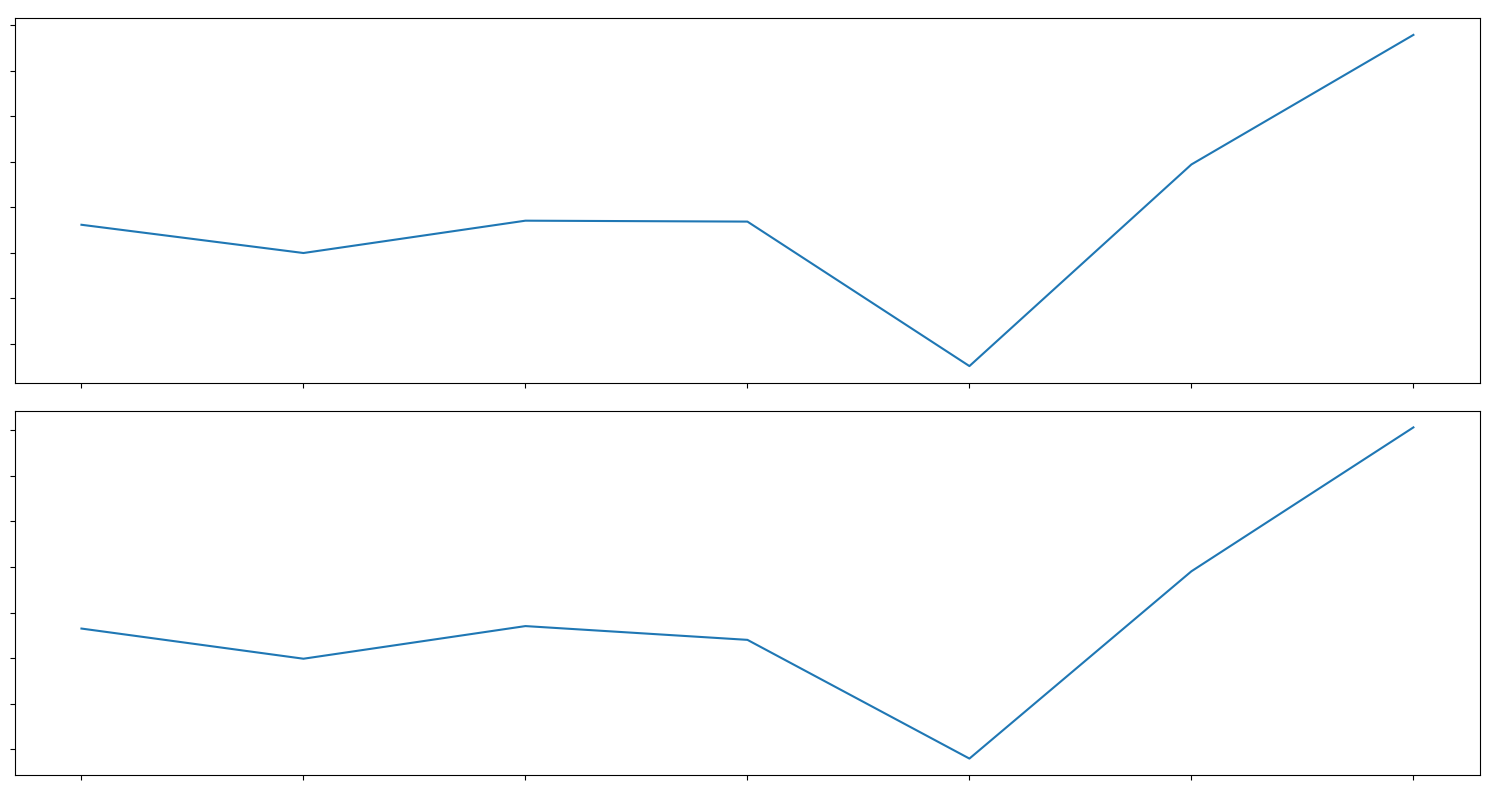

In [43]:
fig, axes = plt.subplots(2, figsize=(15,8))

sns.lineplot(x='day_of_week',y='target',data=train_day,ax=axes[0]).set(title='day_of_week vs target')
sns.lineplot(x='day_of_week',y='target',data=train_day_exc_7,ax=axes[1]).set(title='day_of_week vs target')

plt.rcParams['font.family'] = 'STIXNonUnicode'
plt.tight_layout()
plt.show()

- 7월과 주말의 연관성은 없어보인다.

- 관광객, 시민 들의 교통량 비교


-  월별 요일

### 공휴일 시각화

공휴일 데이터 불러오기

In [44]:
def get_holiday_data(year):
    url = 'http://apis.data.go.kr/B090041/openapi/service/SpcdeInfoService/getRestDeInfo'
    params = {
        'serviceKey': 'lUyD7/c6oiXRywzql7NJsMdnhrTjYOH+Rx/4siN3lV2/J2bWu4UfjpTnBTl150QccIo/8rglYGnTQW2XaKH81g==',
        'solYear': str(year),
        'numOfRows': '100' 
    }

    response = requests.get(url, params=params)
    xml_data = response.content
    json_data = json.dumps(xmltodict.parse(xml_data), indent=4)

    data = json.loads(json_data)

    items = data['response']['body']['items']['item']
    holiday_data = pd.DataFrame(items)

    return holiday_data

holiday_2021 = get_holiday_data(2021)
holiday_2022 = get_holiday_data(2022)

holiday_data = pd.concat([holiday_2021, holiday_2022],ignore_index=True)[['dateName','locdate']]
holiday_data["datetime"] = pd.to_datetime(holiday_data["locdate"],format='%Y%m%d')

holiday_data
# holiday_data.to_csv('./data/holiday.csv', index=False)

,dateName,locdate,datetime
0,1월1일,20210101,2021-01-01
1,설날,20210211,2021-02-11
2,설날,20210212,2021-02-12
3,설날,20210213,2021-02-13
4,삼일절,20210301,2021-03-01
5,어린이날,20210505,2021-05-05
6,부처님오신날,20210519,2021-05-19
7,현충일,20210606,2021-06-06
8,광복절,20210815,2021-08-15
9,대체공휴일,20210816,2021-08-16


In [45]:
# 공휴일이면 is_holiday에 'Y' 값 표시
train['is_holiday'] = train['datetime'].isin(holiday_data['datetime']).map({True: 'Y', False: 'N'})

- 데이터 확인 필요 없을수 있음

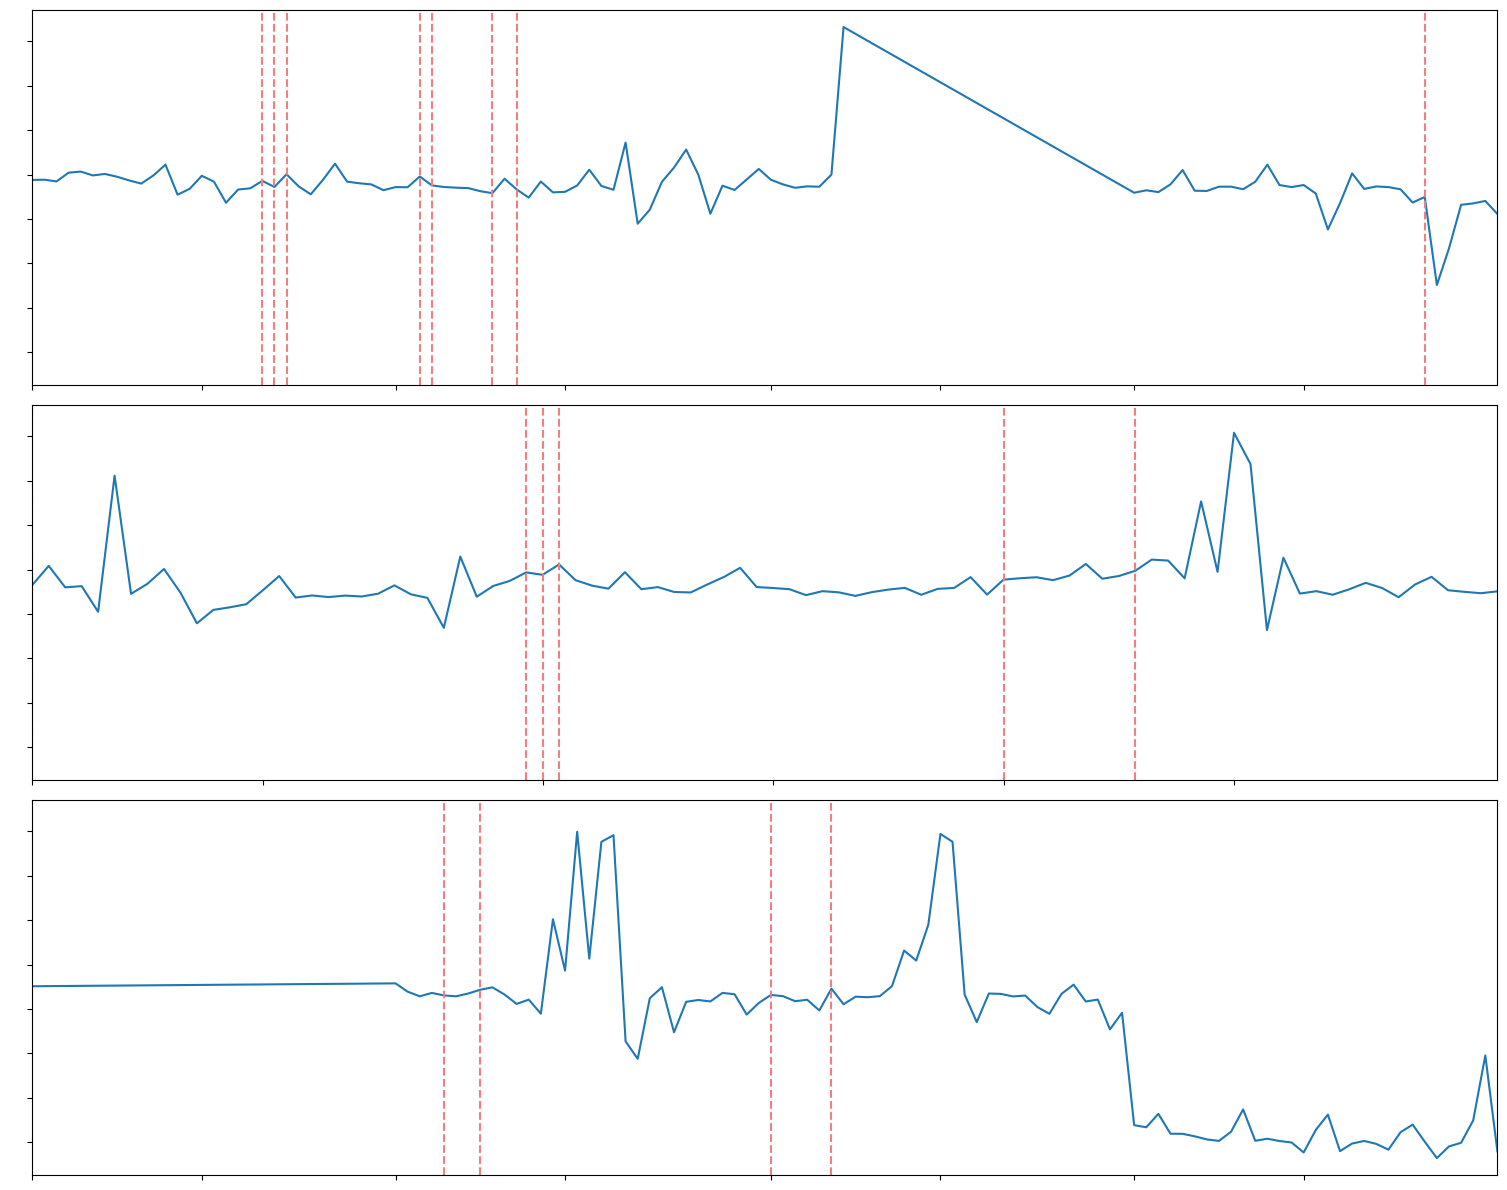

In [46]:
train_date = train[['datetime','target']]
train_date = train_date.groupby('datetime').mean().reset_index()
train_date['is_holiday'] = train_date['datetime'].isin(holiday_data['datetime']).map({True: 'Y', False: 'N'})

fig, axes = plt.subplots(3, figsize=(15,12))
sns.lineplot(x='datetime',y='target',data=train_date,ax=axes[0])
sns.lineplot(x='datetime',y='target',data=train_date,ax=axes[1])
sns.lineplot(x='datetime',y='target',data=train_date,ax=axes[2])

axes[0].set_xlim([datetime(2021, 9, 1), datetime(2021, 12, 31)])
axes[1].set_xlim([datetime(2022, 1, 1), datetime(2022, 3, 31)])
axes[2].set_xlim([datetime(2022, 4, 1), datetime(2022, 7, 31)])

for ax in axes:
    for _, row in train_date[train_date['is_holiday'] == 'Y'].iterrows():
        ax.axvline(x=row['datetime'], color='lightcoral', linestyle='--')

# plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### 기온 - 교통량 

In [120]:
# 제주도 기온, 강수 csv 파일 불러오기
def read_csv_jeju(filename):
    filename = pd.read_csv(f"./data/{filename}.csv", encoding='euc-kr')
    filename['날짜'] = filename['날짜'].str.replace('\t','')
    filename["날짜"] = pd.to_datetime(filename["날짜"],format='%Y-%m-%d')
    filename = filename.rename(columns={'날짜':'datetime'})
    return filename

In [127]:
temper = read_csv_jeju('temperature_jeju')[['datetime','평균기온(℃)']]
rain = read_csv_jeju('rain_jeju')[['datetime','강수량(mm)']]
rain.head()
# train = pd.merge(train, temper, on='datetime', how='left')
# train

,datetime,강수량(mm)
0,2021-09-01,14.5
1,2021-09-02,37.8
2,2021-09-03,21.8
3,2021-09-04,NaN
4,2021-09-05,7.6


- 스케일링
- 이동평균 추가
- 바 차트 만들기

In [88]:
merged_df = pd.merge(temper, rain, on='datetime', how='inner')
merged_df = pd.merge(merged_df, train_date, left_on='datetime', right_on='datetime', how='inner')
merged_df.head()

,datetime,평균기온(℃),강수량(mm),target,is_holiday
0,2021-09-01,28.4,14.5,43.760268,N
1,2021-09-02,25.0,37.8,43.769578,N
2,2021-09-03,24.2,21.8,43.692354,N
3,2021-09-04,25.3,NaN,44.084787,N
4,2021-09-05,24.5,7.6,44.136858,N


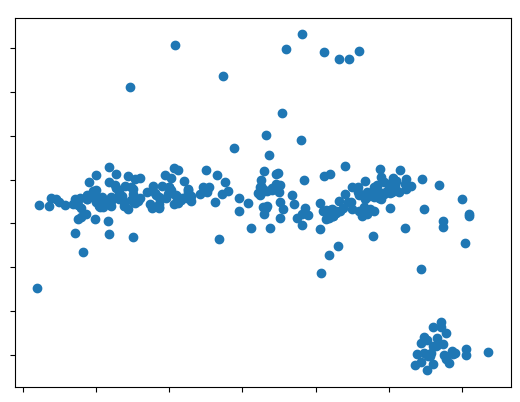

In [82]:
# 온도와 target의 관계 시각화
plt.scatter(merged_df['평균기온(℃)'], merged_df['target'])
plt.xlabel('평균기온(℃)')
plt.ylabel('target')
plt.title('온도와 target의 관계')
plt.show()


In [128]:
# 년/월별 강수량 총 합
rain['year'] = rain['datetime'].dt.year
rain['month'] = rain['datetime'].dt.month
rain = rain[['year','month','강수량(mm)']].groupby(['year','month']).sum('강수량(mm)').reset_index()
rain

,year,month,강수량(mm)
0,2021,9,493.1
1,2021,10,32.1
2,2021,11,63.8
3,2021,12,31.4
4,2022,1,33.6
5,2022,2,25.1
6,2022,3,96.1
7,2022,4,84.0
8,2022,5,9.1
9,2022,6,143.6


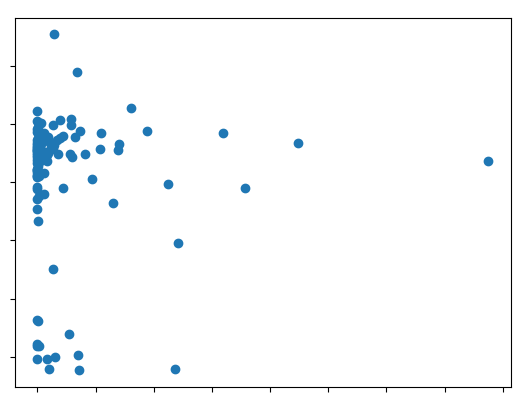

### 지도 시각화

In [30]:
import folium
from folium.plugins import HeatMap

# 지도 중심 위치 설정
center_lat = train['start_latitude'].mean()
center_lon = train['start_longitude'].mean()

# Folium 지도 객체 생성
m = folium.Map(location=[center_lat, center_lon], zoom_start=10)

# 도로 데이터를 순회하며 지도에 표시
for index, row in train.iterrows():
    start_lat = row['start_latitude']
    start_lon = row['start_longitude']
    end_lat = row['end_latitude']
    end_lon = row['end_longitude']
    target = row['target']
    
    # 시작점과 끝점을 선으로 연결
    folium.PolyLine(locations=[(start_lat, start_lon), (end_lat, end_lon)], color='blue').add_to(m)
    
    # 시작점과 끝점을 원으로 표시
    folium.CircleMarker(location=(start_lat, start_lon), radius=5, color='green', fill=True, fill_color='green').add_to(m)
    folium.CircleMarker(location=(end_lat, end_lon), radius=5, color='red', fill=True, fill_color='red').add_to(m)
    
    # 도로의 target을 색으로 표현
    heat_data = [[start_lat, start_lon, target], [end_lat, end_lon, target]]
    HeatMap(heat_data).add_to(m)



### 데이터 전처리

In [6]:
str_col = ['day_of_week','start_turn_restricted','end_turn_restricted']
for i in str_col:
    le = LabelEncoder()
    le=le.fit(train[i])
    train[i]=le.transform(train[i])
    
    for label in np.unique(test[i]):
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test[i]=le.transform(test[i])

In [7]:
y_train = train['target'] 

X_train = train.drop(['id','base_date', 'target','road_name', 'start_node_name', 'end_node_name','vehicle_restricted'], axis=1)

test = test.drop(['id','base_date', 'road_name', 'start_node_name', 'end_node_name','vehicle_restricted'], axis=1)

print(X_train.shape)
print(y_train.shape)
print(test.shape)

(4701217, 16)
(4701217,)
(291241, 16)


### 모델 선언 및 학습

In [8]:
LR = lgb.LGBMRegressor(random_state=42).fit(X_train, y_train)

### 추론

In [10]:
pred = LR.predict(test)

### Submission

In [12]:
sample_submission = pd.read_csv('./data/sample_submission.csv')

In [13]:
sample_submission['target'] = pred
sample_submission.to_csv("./data/submit.csv", index = False)

In [14]:
sample_submission

,id,target
0,TEST_000000,27.298710
1,TEST_000001,43.949243
2,TEST_000002,60.552621
3,TEST_000003,36.499322
4,TEST_000004,37.510570
...,...,...
291236,TEST_291236,45.902276
291237,TEST_291237,52.604831
291238,TEST_291238,21.964371
291239,TEST_291239,25.402628
